## 6. GEM_MOM_Backtest

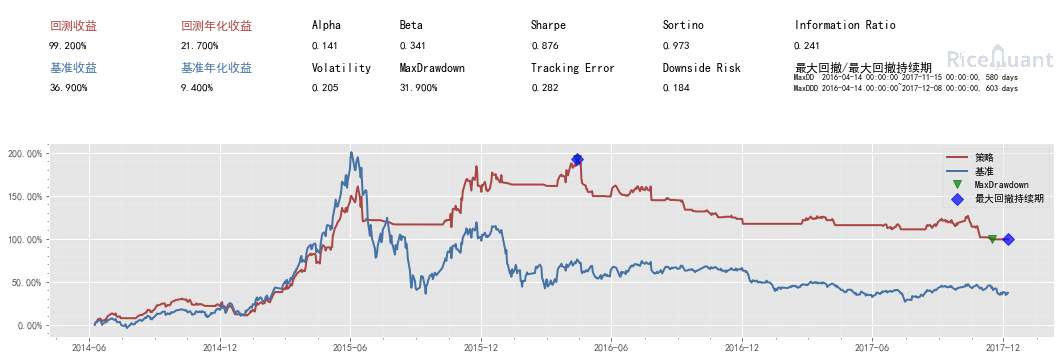

{'sys_analyser': {'benchmark_portfolio':               cash  market_value  static_unit_net_value  total_value  \
  date                                                                   
  2014-06-09  891.68     999108.32                  1.000   1000000.00   
  2014-06-10  891.68    1019588.34                  1.000   1020480.02   
  2014-06-11  891.68    1029762.38                  1.020   1030654.06   
  2014-06-12  891.68    1027226.20                  1.031   1028117.88   
  2014-06-13  891.68    1041571.01                  1.028   1042462.69   
  2014-06-16  891.68    1051275.93                  1.042   1052167.61   
  2014-06-17  891.68    1037678.78                  1.052   1038570.46   
  2014-06-18  891.68    1027607.36                  1.039   1028499.04   
  2014-06-19  891.68     995069.49                  1.028    995961.17   
  2014-06-20  891.68    1005140.91                  0.996   1006032.59   
  2014-06-23  891.68    1025708.89                  1.006   1026600.57   

In [2]:
import numpy as np
import talib as ta
import pandas as pd
import os
import rqalpha
from rqalpha.api import *

def init(context):
    context.gem = '399606.XSHE'
    context.codes = pd.read_excel('gem_factor.xlsx', index_col='date')
    scheduler.run_weekly(find_pool, tradingday=1)

def find_pool(context, bar_dict):
    codes = context.codes.loc[context.now]
    stocks = codes.index[codes == 1]
    context.stocks = stocks

def handle_bar(context, bar_dict):
    if can_trade(context):
        buy(context, bar_dict)

def buy(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)

        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        result = []
        for codes in pool:
            if codes not in result and codes not in context.portfolio.positions:
                result.append(codes)
        if len(result):
            for r in result:
                order_target_percent(r, 1.0/stocks_len)

def sell_all(context):
    for stock in context.portfolio.positions:
        order_target_percent(stock, 0)

def can_trade(context):
    try:
        gem_price = history_bars(context.gem,61,'1d','close')
        gem_ma = ta.MA(gem_price,40)
        if gem_price[-1]<gem_ma[-1]:
            sell_all(context)
            return False
        else:
            return True
    except KeyError:
        return

config = {
    "base": {
        "start_date": "2014-06-07",
        "end_date": "2017-12-10",
        "frequency": '1d',
        "accounts": {'stock':1000000},
        "benchmark": "399606.XSHE"
    },
    "extra": {
        "log_level": "error",
    },
    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True
        }
    }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)